In [19]:
import datetime
import requests
from io import BytesIO

import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from PIL import Image

from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor


pd.set_option('display.max_columns', None)

In [2]:
raw_data = pd.read_csv('/content/drive/MyDrive/데이터/유튜브 트렌드 데이터/KR_youtube_trending_data_0506.csv')
raw_data.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,uq5LClQN3cE,안녕하세요 보겸입니다,2020-08-09T09:32:48Z,UCu9BCtGIEr73LXZsKmoujKw,보겸 BK,24,2020-08-12T00:00:00Z,보겸|bokyem,5947503,53326,105756,139946,https://i.ytimg.com/vi/uq5LClQN3cE/default.jpg,False,False,NaN
1,I-ZbZCHsHD0,부락토스의 계획 [총몇명 프리퀄],2020-08-12T09:00:08Z,UCRuSxVu4iqTK5kCh90ntAgA,총몇명,1,2020-08-12T00:00:00Z,총몇명|재밌는 만화|부락토스|루시퍼|총몇명 프리퀄|총몇명 스토리,963384,28244,494,3339,https://i.ytimg.com/vi/I-ZbZCHsHD0/default.jpg,False,False,"오늘도 정말 감사드립니다!!총몇명 스튜디오 - 총몇명, 십제곱, 5G민, MOVE혁..."
2,9d7jNUjBoss,평생 반성하면서 살겠습니다.,2020-08-10T09:54:13Z,UCMVC92EOs9yDJG5JS-CMesQ,양팡 YangPang,22,2020-08-12T00:00:00Z,양팡|양팡유튜브|팡튜브|가족시트콤|양팡가족|양팡가족시트콤|양팡언니|현실남매|현실자매...,2950885,17974,68898,50688,https://i.ytimg.com/vi/9d7jNUjBoss/default.jpg,False,False,NaN
3,3pI_L3-sMVg,안녕하세요 꽈뚜룹입니다.,2020-08-11T15:00:58Z,UCkQCwnkQfgSuPTTnw_Y7v7w,꽈뚜룹 Quaddurup,24,2020-08-12T00:00:00Z,꽈뚜룹|한국여행기|quaddurup|뚜룹이|korea|southkorea|vlog|...,1743374,36893,1798,8751,https://i.ytimg.com/vi/3pI_L3-sMVg/default.jpg,False,False,앞으로 좀 더 깔끔한 영상제작 약속 드리겠습니다.늘 감사드립니다
4,zrsBjYukE8s,박진영 (J.Y. Park) When We Disco (Duet with 선미) M/V,2020-08-11T09:00:13Z,UCaO6TYtlC8U5ttz62hTrZgg,JYP Entertainment,10,2020-08-12T00:00:00Z,JYP Entertainment|JYP|J.Y.Park|JYPark|박진영|선미|S...,3433885,353337,9763,23405,https://i.ytimg.com/vi/zrsBjYukE8s/default.jpg,False,False,MelOn http://kko.to/TWyXd7zYjSpotify https://s...


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124354 entries, 0 to 124353
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   video_id           124354 non-null  object
 1   title              124354 non-null  object
 2   publishedAt        124354 non-null  object
 3   channelId          124354 non-null  object
 4   channelTitle       124354 non-null  object
 5   categoryId         124354 non-null  int64 
 6   trending_date      124354 non-null  object
 7   tags               124354 non-null  object
 8   view_count         124354 non-null  int64 
 9   likes              124354 non-null  int64 
 10  dislikes           124354 non-null  int64 
 11  comment_count      124354 non-null  int64 
 12  thumbnail_link     124354 non-null  object
 13  comments_disabled  124354 non-null  bool  
 14  ratings_disabled   124354 non-null  bool  
 15  description        120933 non-null  object
dtypes: bool(2), int64(5)

In [4]:
raw_data.isnull().sum()

video_id                0
title                   0
publishedAt             0
channelId               0
channelTitle            0
categoryId              0
trending_date           0
tags                    0
view_count              0
likes                   0
dislikes                0
comment_count           0
thumbnail_link          0
comments_disabled       0
ratings_disabled        0
description          3421
dtype: int64

In [5]:
raw_data['comments_disabled'][raw_data['comments_disabled'] == True].sum()

600

In [6]:
raw_data['ratings_disabled'][raw_data['ratings_disabled'] == True].sum()

1830

In [7]:
for i in list(raw_data):
    print(i)
    print(raw_data[i].duplicated().value_counts())
    print('\n')

video_id
True     108738
False     15616
Name: video_id, dtype: int64


title
True     107673
False     16681
Name: title, dtype: int64


publishedAt
True     108957
False     15397
Name: publishedAt, dtype: int64


channelId
True     121581
False      2773
Name: channelId, dtype: int64


channelTitle
True     121419
False      2935
Name: channelTitle, dtype: int64


categoryId
True     124339
False        15
Name: categoryId, dtype: int64


trending_date
True     123737
False       617
Name: trending_date, dtype: int64


tags
True     112861
False     11493
Name: tags, dtype: int64


view_count
False    120035
True       4319
Name: view_count, dtype: int64


likes
True     74028
False    50326
Name: likes, dtype: int64


dislikes
True     117479
False      6875
Name: dislikes, dtype: int64


comment_count
True     107346
False     17008
Name: comment_count, dtype: int64


thumbnail_link
True     108738
False     15616
Name: thumbnail_link, dtype: int64


comments_disabled
True     124

In [8]:
df = raw_data[(raw_data['comments_disabled'] != 1) & (raw_data['ratings_disabled'] != 1) & (raw_data['categoryId'] == 23)].copy()

In [9]:
df

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
8,7FOi40uehC4,집에 혼자 있을 때 하는 짓ㅋㅋㅋㅋㅋㅋㅋ [밍꼬발랄],2020-08-12T09:00:02Z,UCCJkwrmhIqWkSFV-sQol4Qw,밍꼬발랄Mingggo,23,2020-08-12T00:00:00Z,밍꼬발랄|밍꼬|꼬밍|발랄|모아보기|이어보기|정주행|꿀잼|꿀팁|유형|유형별|꼭있는유형...,340149,13166,338,5697,https://i.ytimg.com/vi/7FOi40uehC4/default.jpg,False,False,다~해 본 사람 손!![밍꼬 배경화면]_https://grafolio.naver.c...
9,0dsnm3n6ZdM,정윤호가 무려 6시간 공들여 만든 세기의 발명품 [발명왕] Ep.1,2020-08-11T09:30:00Z,UC0SoPwEH3idvemSDvKaYgGA,달라스튜디오,23,2020-08-12T00:00:00Z,예능|달라스튜디오|DALLA|정윤호|발명왕|유노윤호|동방신기|TVXQ|신발|아이디어,351264,11125,103,2324,https://i.ytimg.com/vi/0dsnm3n6ZdM/default.jpg,False,False,되게 쓸모 없을 거 같은데 되게 쓸모 있을 거 같은 이 발명품은 뭐지?3:26 ㅅ....
11,7Y8Vv_KHp7I,🇺🇲🇪🇸SUB] [몰카] 누가봐도 강도인데 전혀 의심을 안하는 직원을 본다면?!!!...,2020-08-09T11:30:01Z,UCIuFnJrRwHEUcIVtozJnUGA,동네놈들,23,2020-08-12T00:00:00Z,관찰|관찰카메라|실험|실험카메라|prank|prankcam|prankcamera|p...,1354418,21632,1309,1166,https://i.ytimg.com/vi/7Y8Vv_KHp7I/default.jpg,False,False,장소 협찬을 해주신 청담 레스티아(LESTIA) 감사드립니다 :-)청담 레스티아(L...
25,2ErtcO2XuYs,자수 하겠습니다 죄송합니다,2020-08-10T12:50:44Z,UCg_lS-XS9Fh9I6Rl56Z8fpg,최고다윽박EUGBAK,23,2020-08-12T00:00:00Z,최고다윽박|자연인|바다|낚시|요리먹방|시골|아프리카TV|국민바보|eugbak|muk...,1118238,32497,2696,11910,https://i.ytimg.com/vi/2ErtcO2XuYs/default.jpg,False,False,죄송합니다
27,5UahGcQ5u9k,치킨 본사 쳐들어가서 네고해왔습니다 [네고왕] Ep.1,2020-08-07T09:30:00Z,UC0SoPwEH3idvemSDvKaYgGA,달라스튜디오,23,2020-08-12T00:00:00Z,예능|달라스튜디오|DALLA|치킨|비비큐|BBQ,2963213,166050,1342,18128,https://i.ytimg.com/vi/5UahGcQ5u9k/default.jpg,False,False,9:16 치킨왕 앞에서 쫄리는 법이 없는 천직 네고왕ㅋㅋㅋㅋㅋㅋㅋBBQ 통장에서 5...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124279,OcE_DzYE_AM,소울리스좌 본캐 김한나,2022-04-27T09:00:11Z,UCILgj-Cl3aneZBoK3l_gasw,티타남,23,2022-05-06T00:00:00Z,에버랜드|티타남|아마존|티익스프레스|아마존익스프레스|알바|어트랙션|직원|에버랜드직원...,827472,9404,0,1088,https://i.ytimg.com/vi/OcE_DzYE_AM/default.jpg,False,False,귀한 분 모시고 인터뷰 나눠보았습니다.쿠키영상에 거대한 떡밥이 투척되는데..?***...
124299,C_a_ZgyQYhU,[꿈탈출] 질투의 꿈 2화,2022-04-29T06:00:04Z,UCZ0dIs-Ao2v8eZF4WOYH5uw,썰레임 Ssuleim,23,2022-05-06T00:00:00Z,꿈탈출|꿈애니메이션|꿈의신|탈출꿈|꿈애니|썰레임|썰레툰|영상툰|유튜브애니|유튜브애니...,172865,2987,0,617,https://i.ytimg.com/vi/C_a_ZgyQYhU/default.jpg,False,False,"썰레임의 창작세계관 기반 애니메이션,꿈탈출의 챕터4 인 질투의 꿈 챕터의 2화 입니..."
124314,JPaubSOSxeM,오늘 수정이네 집에서 자고 가려고,2022-04-23T09:00:07Z,UCXEKwWflysXu312NmIP_dlw,너덜트,23,2022-05-06T00:00:00Z,[None],4052235,80111,0,3824,https://i.ytimg.com/vi/JPaubSOSxeM/default.jpg,False,False,#코믹숏무비 #nerdult #외박부모님 속이고 외박할 때장소 협찬 : 퍼핀스베이 ...
124322,XW-7tsRtCEo,[밥묵자] 미운 새끼 (feat. 김지민 남친),2022-04-23T12:00:16Z,UCSc2DcSzzjHgBn8Hg0KG7PA,꼰대희,23,2022-05-06T00:00:00Z,꼰대희|김대희|밥묵자|장동민|신봉선|유세윤|개콘|개콘레전드,1822078,27473,0,1057,https://i.ytimg.com/vi/XW-7tsRtCEo/default.jpg,False,False,#꼰대희 #김준호 #밥묵자*비즈니스 문의jdbent001@gmail.com*틱톡ht...


In [10]:
print('Before dropna:', len(df))
df = df.dropna()
print('After dropna:', len(df))
df = df.reset_index(drop=True)

Before dropna: 7800
After dropna: 6977


In [11]:
df['publish_date'] = df['publishedAt'].apply(lambda x: x.split('T')[0])
df['publish_date'] = df['publish_date'].astype('datetime64[ns]')

df['trend_date'] = df['trending_date'].apply(lambda x: x.split('T')[0])
df['trend_date'] = df['trend_date'].astype('datetime64[ns]')

In [12]:
print(df['publish_date'][:1])
print(df['publish_date'][-1:])

0   2020-08-12
Name: publish_date, dtype: datetime64[ns]
6976   2022-04-24
Name: publish_date, dtype: datetime64[ns]


In [13]:
print(df['trend_date'][:1])
print(df['trend_date'][-1:])

0   2020-08-12
Name: trend_date, dtype: datetime64[ns]
6976   2022-05-06
Name: trend_date, dtype: datetime64[ns]


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6977 entries, 0 to 6976
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   video_id           6977 non-null   object        
 1   title              6977 non-null   object        
 2   publishedAt        6977 non-null   object        
 3   channelId          6977 non-null   object        
 4   channelTitle       6977 non-null   object        
 5   categoryId         6977 non-null   int64         
 6   trending_date      6977 non-null   object        
 7   tags               6977 non-null   object        
 8   view_count         6977 non-null   int64         
 9   likes              6977 non-null   int64         
 10  dislikes           6977 non-null   int64         
 11  comment_count      6977 non-null   int64         
 12  thumbnail_link     6977 non-null   object        
 13  comments_disabled  6977 non-null   bool          
 14  ratings_

In [15]:
df.shape

(6977, 18)

In [16]:
len(df[df['trend_date'] >= '2021-05-06'])

3817

In [17]:
df = df[df['trend_date'] >= '2021-05-06'].copy()
df = df.reset_index(drop=True)

In [18]:
df

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,publish_date,trend_date
0,5E7SrcLXQ5I,[MadTV] Mad Monster - episode. chicken (daddy ...,2021-05-05T11:00:03Z,UCqsPmfRMm0AGTF3mw1VtCnw,빵송국,23,2021-05-06T00:00:00Z,[None],557700,11892,153,2663,https://i.ytimg.com/vi/5E7SrcLXQ5I/default.jpg,False,False,#매드몬스터 #대디 #쿠폰 ↓링크를 통해 응모해주시는 분들 중 30명 추첨하여 치킨...,2021-05-05,2021-05-06
1,ISQMlzGG_DM,어린이날에 전재산을 걸고 초딩 때 하고 싶었던 것들 강제로 싹 다 Flex하기ㅋㅋㅋㅋㅋ,2021-05-05T07:45:00Z,UCoe_Vp6N4pBX0232Y5LpD5Q,돌잼,23,2021-05-06T00:00:00Z,돌잼|돌잼패러디|보물섬|더블비|싱호|레이디액션|웃긴영상|재밌는영상|패러디|패러디레전...,264024,4353,127,983,https://i.ytimg.com/vi/ISQMlzGG_DM/default.jpg,False,False,오늘도 싹 다 FLEX 해볼까~??돌잼 구독!! 좋아요!! 알림on!!★인스타★ht...,2021-05-05,2021-05-06
2,ZGCcWPcDooY,[몰카] 간장게장집에서 반말로 진상부리다 개털리는 진상 깔고아저씨!!ㅋㅋㅋㅋㅋ 아 ...,2021-05-02T06:30:03Z,UCQmu3URPR1PXJUZPQTD4QZQ,희극인,23,2021-05-06T00:00:00Z,웃긴영상|개그우먼|신윤승|웃음참기|개그맨몰카|깔고아저씨|prank|spycam|co...,612460,7936,263,547,https://i.ytimg.com/vi/ZGCcWPcDooY/default.jpg,False,False,#몰카 #노랑머리양아치 #삼순이게장 #신윤승 #박민성장소협찬 : 김포공항근처 가성비...,2021-05-02,2021-05-06
3,8rpzKC7gR3w,이호창. 인턴 직원에게 갑질 (유출영상),2021-05-01T11:00:03Z,UCqsPmfRMm0AGTF3mw1VtCnw,빵송국,23,2021-05-06T00:00:00Z,[None],1536040,19790,411,3053,https://i.ytimg.com/vi/8rpzKC7gR3w/default.jpg,False,False,[받은글]김갑생 할머니김 미래전략실 전략본부장 이호창.'김갑생할머니김 리뉴얼 출시'...,2021-05-01,2021-05-06
4,qVOMWyHJx98,"대망의 마지막화, 토스트왕 만나고 왔습니다 (눈물주의) [네고왕2] Ep.10",2021-04-30T09:30:16Z,UC0SoPwEH3idvemSDvKaYgGA,달라스튜디오,23,2021-05-06T00:00:00Z,예능|달라스튜디오|DALLA|이삭토스트|장영란|네고왕|유퀴즈|햄치즈토스트|toast...,2275524,64051,474,8768,https://i.ytimg.com/vi/qVOMWyHJx98/default.jpg,False,False,16:41 천사를 찾습니다.. 선팩폭 후네고 [네고왕2]🔔 매주 금요일 오후 6시 ...,2021-04-30,2021-05-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3812,OcE_DzYE_AM,소울리스좌 본캐 김한나,2022-04-27T09:00:11Z,UCILgj-Cl3aneZBoK3l_gasw,티타남,23,2022-05-06T00:00:00Z,에버랜드|티타남|아마존|티익스프레스|아마존익스프레스|알바|어트랙션|직원|에버랜드직원...,827472,9404,0,1088,https://i.ytimg.com/vi/OcE_DzYE_AM/default.jpg,False,False,귀한 분 모시고 인터뷰 나눠보았습니다.쿠키영상에 거대한 떡밥이 투척되는데..?***...,2022-04-27,2022-05-06
3813,C_a_ZgyQYhU,[꿈탈출] 질투의 꿈 2화,2022-04-29T06:00:04Z,UCZ0dIs-Ao2v8eZF4WOYH5uw,썰레임 Ssuleim,23,2022-05-06T00:00:00Z,꿈탈출|꿈애니메이션|꿈의신|탈출꿈|꿈애니|썰레임|썰레툰|영상툰|유튜브애니|유튜브애니...,172865,2987,0,617,https://i.ytimg.com/vi/C_a_ZgyQYhU/default.jpg,False,False,"썰레임의 창작세계관 기반 애니메이션,꿈탈출의 챕터4 인 질투의 꿈 챕터의 2화 입니...",2022-04-29,2022-05-06
3814,JPaubSOSxeM,오늘 수정이네 집에서 자고 가려고,2022-04-23T09:00:07Z,UCXEKwWflysXu312NmIP_dlw,너덜트,23,2022-05-06T00:00:00Z,[None],4052235,80111,0,3824,https://i.ytimg.com/vi/JPaubSOSxeM/default.jpg,False,False,#코믹숏무비 #nerdult #외박부모님 속이고 외박할 때장소 협찬 : 퍼핀스베이 ...,2022-04-23,2022-05-06
3815,XW-7tsRtCEo,[밥묵자] 미운 새끼 (feat. 김지민 남친),2022-04-23T12:00:16Z,UCSc2DcSzzjHgBn8Hg0KG7PA,꼰대희,23,2022-05-06T00:00:00Z,꼰대희|김대희|밥묵자|장동민|신봉선|유세윤|개콘|개콘레전드,1822078,27473,0,1057,https://i.ytimg.com/vi/XW-7tsRtCEo/default.jpg,False,False,#꼰대희 #김준호 #밥묵자*비즈니스 문의jdbent001@gmail.com*틱톡ht...,2022-04-23,2022-05-06


In [20]:
# 카테고리 23 최근 1년 데이터(3817개) : 실행 시간 1분 25초 소요

r_avg = []
g_avg = []
b_avg = []

for i in tqdm.tqdm(range(len(df))):
    url = df['thumbnail_link'][i]
    res = requests.get(url)
    request_get_img = Image.open(BytesIO(res.content))
    red, green, blue = request_get_img.split()

    r_avg.append(int(np.average(red)))
    g_avg.append(int(np.average(green)))
    b_avg.append(int(np.average(blue)))

df['r_avg'] = r_avg
df['g_avg'] = g_avg
df['b_avg'] = b_avg

100%|██████████| 3817/3817 [01:27<00:00, 43.83it/s]


In [21]:
df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,publish_date,trend_date,r_avg,g_avg,b_avg
0,5E7SrcLXQ5I,[MadTV] Mad Monster - episode. chicken (daddy ...,2021-05-05T11:00:03Z,UCqsPmfRMm0AGTF3mw1VtCnw,빵송국,23,2021-05-06T00:00:00Z,[None],557700,11892,153,2663,https://i.ytimg.com/vi/5E7SrcLXQ5I/default.jpg,False,False,#매드몬스터 #대디 #쿠폰 ↓링크를 통해 응모해주시는 분들 중 30명 추첨하여 치킨...,2021-05-05,2021-05-06,123,121,121
1,ISQMlzGG_DM,어린이날에 전재산을 걸고 초딩 때 하고 싶었던 것들 강제로 싹 다 Flex하기ㅋㅋㅋㅋㅋ,2021-05-05T07:45:00Z,UCoe_Vp6N4pBX0232Y5LpD5Q,돌잼,23,2021-05-06T00:00:00Z,돌잼|돌잼패러디|보물섬|더블비|싱호|레이디액션|웃긴영상|재밌는영상|패러디|패러디레전...,264024,4353,127,983,https://i.ytimg.com/vi/ISQMlzGG_DM/default.jpg,False,False,오늘도 싹 다 FLEX 해볼까~??돌잼 구독!! 좋아요!! 알림on!!★인스타★ht...,2021-05-05,2021-05-06,138,97,60
2,ZGCcWPcDooY,[몰카] 간장게장집에서 반말로 진상부리다 개털리는 진상 깔고아저씨!!ㅋㅋㅋㅋㅋ 아 ...,2021-05-02T06:30:03Z,UCQmu3URPR1PXJUZPQTD4QZQ,희극인,23,2021-05-06T00:00:00Z,웃긴영상|개그우먼|신윤승|웃음참기|개그맨몰카|깔고아저씨|prank|spycam|co...,612460,7936,263,547,https://i.ytimg.com/vi/ZGCcWPcDooY/default.jpg,False,False,#몰카 #노랑머리양아치 #삼순이게장 #신윤승 #박민성장소협찬 : 김포공항근처 가성비...,2021-05-02,2021-05-06,106,99,97
3,8rpzKC7gR3w,이호창. 인턴 직원에게 갑질 (유출영상),2021-05-01T11:00:03Z,UCqsPmfRMm0AGTF3mw1VtCnw,빵송국,23,2021-05-06T00:00:00Z,[None],1536040,19790,411,3053,https://i.ytimg.com/vi/8rpzKC7gR3w/default.jpg,False,False,[받은글]김갑생 할머니김 미래전략실 전략본부장 이호창.'김갑생할머니김 리뉴얼 출시'...,2021-05-01,2021-05-06,58,67,76
4,qVOMWyHJx98,"대망의 마지막화, 토스트왕 만나고 왔습니다 (눈물주의) [네고왕2] Ep.10",2021-04-30T09:30:16Z,UC0SoPwEH3idvemSDvKaYgGA,달라스튜디오,23,2021-05-06T00:00:00Z,예능|달라스튜디오|DALLA|이삭토스트|장영란|네고왕|유퀴즈|햄치즈토스트|toast...,2275524,64051,474,8768,https://i.ytimg.com/vi/qVOMWyHJx98/default.jpg,False,False,16:41 천사를 찾습니다.. 선팩폭 후네고 [네고왕2]🔔 매주 금요일 오후 6시 ...,2021-04-30,2021-05-06,118,88,67


---

In [22]:
check_table = df[(df['r_avg'] == df['g_avg']) & (df['g_avg'] == df['b_avg']) & (df['b_avg'] == df['r_avg'])]
print('len_check_table:', len(check_table))

len_check_table: 37


In [23]:
check_table.iloc[:, -3:]

,r_avg,g_avg,b_avg
40,193,193,193
52,0,0,0
53,193,193,193
64,0,0,0
75,0,0,0
87,0,0,0
100,0,0,0
111,0,0,0
124,0,0,0
139,0,0,0


In [30]:
df[~((df['r_avg'] == df['g_avg']) & (df['g_avg'] == df['b_avg']) & (df['b_avg'] == df['r_avg']))]

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,publish_date,trend_date,r_avg,g_avg,b_avg
0,5E7SrcLXQ5I,[MadTV] Mad Monster - episode. chicken (daddy ...,2021-05-05T11:00:03Z,UCqsPmfRMm0AGTF3mw1VtCnw,빵송국,23,2021-05-06T00:00:00Z,[None],557700,11892,153,2663,https://i.ytimg.com/vi/5E7SrcLXQ5I/default.jpg,False,False,#매드몬스터 #대디 #쿠폰 ↓링크를 통해 응모해주시는 분들 중 30명 추첨하여 치킨...,2021-05-05,2021-05-06,123,121,121
1,ISQMlzGG_DM,어린이날에 전재산을 걸고 초딩 때 하고 싶었던 것들 강제로 싹 다 Flex하기ㅋㅋㅋㅋㅋ,2021-05-05T07:45:00Z,UCoe_Vp6N4pBX0232Y5LpD5Q,돌잼,23,2021-05-06T00:00:00Z,돌잼|돌잼패러디|보물섬|더블비|싱호|레이디액션|웃긴영상|재밌는영상|패러디|패러디레전...,264024,4353,127,983,https://i.ytimg.com/vi/ISQMlzGG_DM/default.jpg,False,False,오늘도 싹 다 FLEX 해볼까~??돌잼 구독!! 좋아요!! 알림on!!★인스타★ht...,2021-05-05,2021-05-06,138,97,60
2,ZGCcWPcDooY,[몰카] 간장게장집에서 반말로 진상부리다 개털리는 진상 깔고아저씨!!ㅋㅋㅋㅋㅋ 아 ...,2021-05-02T06:30:03Z,UCQmu3URPR1PXJUZPQTD4QZQ,희극인,23,2021-05-06T00:00:00Z,웃긴영상|개그우먼|신윤승|웃음참기|개그맨몰카|깔고아저씨|prank|spycam|co...,612460,7936,263,547,https://i.ytimg.com/vi/ZGCcWPcDooY/default.jpg,False,False,#몰카 #노랑머리양아치 #삼순이게장 #신윤승 #박민성장소협찬 : 김포공항근처 가성비...,2021-05-02,2021-05-06,106,99,97
3,8rpzKC7gR3w,이호창. 인턴 직원에게 갑질 (유출영상),2021-05-01T11:00:03Z,UCqsPmfRMm0AGTF3mw1VtCnw,빵송국,23,2021-05-06T00:00:00Z,[None],1536040,19790,411,3053,https://i.ytimg.com/vi/8rpzKC7gR3w/default.jpg,False,False,[받은글]김갑생 할머니김 미래전략실 전략본부장 이호창.'김갑생할머니김 리뉴얼 출시'...,2021-05-01,2021-05-06,58,67,76
4,qVOMWyHJx98,"대망의 마지막화, 토스트왕 만나고 왔습니다 (눈물주의) [네고왕2] Ep.10",2021-04-30T09:30:16Z,UC0SoPwEH3idvemSDvKaYgGA,달라스튜디오,23,2021-05-06T00:00:00Z,예능|달라스튜디오|DALLA|이삭토스트|장영란|네고왕|유퀴즈|햄치즈토스트|toast...,2275524,64051,474,8768,https://i.ytimg.com/vi/qVOMWyHJx98/default.jpg,False,False,16:41 천사를 찾습니다.. 선팩폭 후네고 [네고왕2]🔔 매주 금요일 오후 6시 ...,2021-04-30,2021-05-06,118,88,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3812,OcE_DzYE_AM,소울리스좌 본캐 김한나,2022-04-27T09:00:11Z,UCILgj-Cl3aneZBoK3l_gasw,티타남,23,2022-05-06T00:00:00Z,에버랜드|티타남|아마존|티익스프레스|아마존익스프레스|알바|어트랙션|직원|에버랜드직원...,827472,9404,0,1088,https://i.ytimg.com/vi/OcE_DzYE_AM/default.jpg,False,False,귀한 분 모시고 인터뷰 나눠보았습니다.쿠키영상에 거대한 떡밥이 투척되는데..?***...,2022-04-27,2022-05-06,114,115,121
3813,C_a_ZgyQYhU,[꿈탈출] 질투의 꿈 2화,2022-04-29T06:00:04Z,UCZ0dIs-Ao2v8eZF4WOYH5uw,썰레임 Ssuleim,23,2022-05-06T00:00:00Z,꿈탈출|꿈애니메이션|꿈의신|탈출꿈|꿈애니|썰레임|썰레툰|영상툰|유튜브애니|유튜브애니...,172865,2987,0,617,https://i.ytimg.com/vi/C_a_ZgyQYhU/default.jpg,False,False,"썰레임의 창작세계관 기반 애니메이션,꿈탈출의 챕터4 인 질투의 꿈 챕터의 2화 입니...",2022-04-29,2022-05-06,137,133,37
3814,JPaubSOSxeM,오늘 수정이네 집에서 자고 가려고,2022-04-23T09:00:07Z,UCXEKwWflysXu312NmIP_dlw,너덜트,23,2022-05-06T00:00:00Z,[None],4052235,80111,0,3824,https://i.ytimg.com/vi/JPaubSOSxeM/default.jpg,False,False,#코믹숏무비 #nerdult #외박부모님 속이고 외박할 때장소 협찬 : 퍼핀스베이 ...,2022-04-23,2022-05-06,86,77,70
3815,XW-7tsRtCEo,[밥묵자] 미운 새끼 (feat. 김지민 남친),2022-04-23T12:00:16Z,UCSc2DcSzzjHgBn8Hg0KG7PA,꼰대희,23,2022-05-06T00:00:00Z,꼰대희|김대희|밥묵자|장동민|신봉선|유세윤|개콘|개콘레전드,1822078,27473,0,1057,https://i.ytimg.com/vi/XW-7tsRtCEo/default.jpg,False,False,#꼰대희 #김준호 #밥묵자*비즈니스 문의jdbent001@gmail.com*틱톡ht...,2022-04-23,2022-05-06,103,98,95


In [31]:
print('Before removing non-thumbnail images:', len(df))
df = df[~((df['r_avg'] == df['g_avg']) & (df['g_avg'] == df['b_avg']) & (df['b_avg'] == df['r_avg']))].copy()
print('After removing non-thumbnail images:', len(df))
df = df.reset_index(drop=True)

Before removing non-thumbnail images: 3817
After removing non-thumbnail images: 3780


---

In [32]:
print(df['video_id'].duplicated().value_counts())
df[df.duplicated('video_id')].sort_values(by='video_id')

True     3403
False     377
Name: video_id, dtype: int64


,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,publish_date,trend_date,r_avg,g_avg,b_avg
2093,-7NtwdRzrlQ,1년 뒤에 뵙겠습니다.,2021-12-15T09:24:36Z,UCDV9zgWo7b6nPg7i49oRQ5Q,논리왕 전기,23,2021-12-17T00:00:00Z,논리왕 전기|전기|논리왕|머니게임|머니게임 전기|머니게임 논리왕 전기|코트|약빨방|토크온,635242,13087,0,1910,https://i.ytimg.com/vi/-7NtwdRzrlQ/default.jpg,False,False,#전기 #논리왕 #수능 #대학 #도전건동홍(철학과) 밑의 성적이 나올 시 유튜브 계...,2021-12-15,2021-12-17,95,108,121
2103,-7NtwdRzrlQ,1년 뒤에 뵙겠습니다.,2021-12-15T09:24:36Z,UCDV9zgWo7b6nPg7i49oRQ5Q,논리왕 전기,23,2021-12-18T00:00:00Z,논리왕 전기|전기|논리왕|머니게임|머니게임 전기|머니게임 논리왕 전기|코트|약빨방|토크온,779881,14504,0,2050,https://i.ytimg.com/vi/-7NtwdRzrlQ/default.jpg,False,False,#전기 #논리왕 #수능 #대학 #도전건동홍(철학과) 밑의 성적이 나올 시 유튜브 계...,2021-12-15,2021-12-18,95,108,121
2110,-7NtwdRzrlQ,1년 뒤에 뵙겠습니다.,2021-12-15T09:24:36Z,UCDV9zgWo7b6nPg7i49oRQ5Q,논리왕 전기,23,2021-12-19T00:00:00Z,논리왕 전기|전기|논리왕|머니게임|머니게임 전기|머니게임 논리왕 전기|코트|약빨방|토크온,846862,15059,0,2182,https://i.ytimg.com/vi/-7NtwdRzrlQ/default.jpg,False,False,#전기 #논리왕 #수능 #대학 #도전건동홍(철학과) 밑의 성적이 나올 시 유튜브 계...,2021-12-15,2021-12-19,95,108,121
2117,-7NtwdRzrlQ,1년 뒤에 뵙겠습니다.,2021-12-15T09:24:36Z,UCDV9zgWo7b6nPg7i49oRQ5Q,논리왕 전기,23,2021-12-20T00:00:00Z,논리왕 전기|전기|논리왕|머니게임|머니게임 전기|머니게임 논리왕 전기|코트|약빨방|토크온,868279,15286,0,2187,https://i.ytimg.com/vi/-7NtwdRzrlQ/default.jpg,False,False,#전기 #논리왕 #수능 #대학 #도전건동홍(철학과) 밑의 성적이 나올 시 유튜브 계...,2021-12-15,2021-12-20,95,108,121
2123,-7NtwdRzrlQ,1년 뒤에 뵙겠습니다.,2021-12-15T09:24:36Z,UCDV9zgWo7b6nPg7i49oRQ5Q,논리왕 전기,23,2021-12-21T00:00:00Z,논리왕 전기|전기|논리왕|머니게임|머니게임 전기|머니게임 논리왕 전기|코트|약빨방|토크온,881976,15428,0,2215,https://i.ytimg.com/vi/-7NtwdRzrlQ/default.jpg,False,False,#전기 #논리왕 #수능 #대학 #도전건동홍(철학과) 밑의 성적이 나올 시 유튜브 계...,2021-12-15,2021-12-21,95,108,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,zxuLVGPwGWY,[신병] 보직변경 5,2021-07-29T08:00:10Z,UChbE5OZQ6dRHECsX0tEPEZQ,장삐쭈,23,2021-08-04T00:00:00Z,장삐쭈|삐쭈|ㅋㅋㅋ|삐쮸|장삐쮸|병맛더빙|더빙|웃긴동영상|꿀잼|신병|장삐쭈 단편선|...,3288630,48239,813,20829,https://i.ytimg.com/vi/zxuLVGPwGWY/default.jpg,False,False,"스튜디오 장삐쭈장삐쭈, 정영준, 안류천, 포포, 윤성원, 허혜원, 정대준, 지정민,...",2021-07-29,2021-08-04,152,149,149
1117,zxuLVGPwGWY,[신병] 보직변경 5,2021-07-29T08:00:10Z,UChbE5OZQ6dRHECsX0tEPEZQ,장삐쭈,23,2021-08-05T00:00:00Z,장삐쭈|삐쭈|ㅋㅋㅋ|삐쮸|장삐쮸|병맛더빙|더빙|웃긴동영상|꿀잼|신병|장삐쭈 단편선|...,3372189,48683,835,21120,https://i.ytimg.com/vi/zxuLVGPwGWY/default.jpg,False,False,"스튜디오 장삐쭈장삐쭈, 정영준, 안류천, 포포, 윤성원, 허혜원, 정대준, 지정민,...",2021-07-29,2021-08-05,152,149,149
1150,zxuLVGPwGWY,[신병] 보직변경 5,2021-07-29T08:00:10Z,UChbE5OZQ6dRHECsX0tEPEZQ,장삐쭈,23,2021-08-09T00:00:00Z,장삐쭈|삐쭈|ㅋㅋㅋ|삐쮸|장삐쮸|병맛더빙|더빙|웃긴동영상|꿀잼|신병|장삐쭈 단편선|...,3594055,49676,884,21697,https://i.ytimg.com/vi/zxuLVGPwGWY/default.jpg,False,False,"스튜디오 장삐쭈장삐쭈, 정영준, 안류천, 포포, 윤성원, 허혜원, 정대준, 지정민,...",2021-07-29,2021-08-09,152,149,149
1166,zxuLVGPwGWY,[신병] 보직변경 5,2021-07-29T08:00:10Z,UChbE5OZQ6dRHECsX0tEPEZQ,장삐쭈,23,2021-08-11T00:00:00Z,장삐쭈|삐쭈|ㅋㅋㅋ|삐쮸|장삐쮸|병맛더빙|더빙|웃긴동영상|꿀잼|신병|장삐쭈 단편선|...,3651783,49935,892,21842,https://i.ytimg.com/vi/zxuLVGPwGWY/default.jpg,False,False,"스튜디오 장삐쭈장삐쭈, 정영준, 안류천, 포포, 윤성원, 허혜원, 정대준, 지정민,...",2021-07-29,2021-08-11,152,149,149


In [33]:
df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,publish_date,trend_date,r_avg,g_avg,b_avg
0,5E7SrcLXQ5I,[MadTV] Mad Monster - episode. chicken (daddy ...,2021-05-05T11:00:03Z,UCqsPmfRMm0AGTF3mw1VtCnw,빵송국,23,2021-05-06T00:00:00Z,[None],557700,11892,153,2663,https://i.ytimg.com/vi/5E7SrcLXQ5I/default.jpg,False,False,#매드몬스터 #대디 #쿠폰 ↓링크를 통해 응모해주시는 분들 중 30명 추첨하여 치킨...,2021-05-05,2021-05-06,123,121,121
1,ISQMlzGG_DM,어린이날에 전재산을 걸고 초딩 때 하고 싶었던 것들 강제로 싹 다 Flex하기ㅋㅋㅋㅋㅋ,2021-05-05T07:45:00Z,UCoe_Vp6N4pBX0232Y5LpD5Q,돌잼,23,2021-05-06T00:00:00Z,돌잼|돌잼패러디|보물섬|더블비|싱호|레이디액션|웃긴영상|재밌는영상|패러디|패러디레전...,264024,4353,127,983,https://i.ytimg.com/vi/ISQMlzGG_DM/default.jpg,False,False,오늘도 싹 다 FLEX 해볼까~??돌잼 구독!! 좋아요!! 알림on!!★인스타★ht...,2021-05-05,2021-05-06,138,97,60
2,ZGCcWPcDooY,[몰카] 간장게장집에서 반말로 진상부리다 개털리는 진상 깔고아저씨!!ㅋㅋㅋㅋㅋ 아 ...,2021-05-02T06:30:03Z,UCQmu3URPR1PXJUZPQTD4QZQ,희극인,23,2021-05-06T00:00:00Z,웃긴영상|개그우먼|신윤승|웃음참기|개그맨몰카|깔고아저씨|prank|spycam|co...,612460,7936,263,547,https://i.ytimg.com/vi/ZGCcWPcDooY/default.jpg,False,False,#몰카 #노랑머리양아치 #삼순이게장 #신윤승 #박민성장소협찬 : 김포공항근처 가성비...,2021-05-02,2021-05-06,106,99,97
3,8rpzKC7gR3w,이호창. 인턴 직원에게 갑질 (유출영상),2021-05-01T11:00:03Z,UCqsPmfRMm0AGTF3mw1VtCnw,빵송국,23,2021-05-06T00:00:00Z,[None],1536040,19790,411,3053,https://i.ytimg.com/vi/8rpzKC7gR3w/default.jpg,False,False,[받은글]김갑생 할머니김 미래전략실 전략본부장 이호창.'김갑생할머니김 리뉴얼 출시'...,2021-05-01,2021-05-06,58,67,76
4,qVOMWyHJx98,"대망의 마지막화, 토스트왕 만나고 왔습니다 (눈물주의) [네고왕2] Ep.10",2021-04-30T09:30:16Z,UC0SoPwEH3idvemSDvKaYgGA,달라스튜디오,23,2021-05-06T00:00:00Z,예능|달라스튜디오|DALLA|이삭토스트|장영란|네고왕|유퀴즈|햄치즈토스트|toast...,2275524,64051,474,8768,https://i.ytimg.com/vi/qVOMWyHJx98/default.jpg,False,False,16:41 천사를 찾습니다.. 선팩폭 후네고 [네고왕2]🔔 매주 금요일 오후 6시 ...,2021-04-30,2021-05-06,118,88,67


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3780 entries, 0 to 3779
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   video_id           3780 non-null   object        
 1   title              3780 non-null   object        
 2   publishedAt        3780 non-null   object        
 3   channelId          3780 non-null   object        
 4   channelTitle       3780 non-null   object        
 5   categoryId         3780 non-null   int64         
 6   trending_date      3780 non-null   object        
 7   tags               3780 non-null   object        
 8   view_count         3780 non-null   int64         
 9   likes              3780 non-null   int64         
 10  dislikes           3780 non-null   int64         
 11  comment_count      3780 non-null   int64         
 12  thumbnail_link     3780 non-null   object        
 13  comments_disabled  3780 non-null   bool          
 14  ratings_

In [35]:
df['elapsed_day'] = df['trend_date'] - df['publish_date'] + datetime.timedelta(days=1)
df['elapsed_day'] = df['elapsed_day'].dt.days
df['elapsed_day']

0        2
1        2
2        5
3        6
4        7
        ..
3775    10
3776     8
3777    14
3778    14
3779    13
Name: elapsed_day, Length: 3780, dtype: int64

In [36]:
# 반응도(좋아요 + 싫어요)
df['engagement'] = df['likes'] + df['dislikes']

# 태그 수
df['number_of_tag'] = df['tags'].apply(lambda x: len(x.split('|')) if x != '[None]' else 0)

# 일일 반응도
df['engagement_per_day'] = df['engagement'] / df['elapsed_day']

# 일일 댓글 수
df['comment_per_day'] = df['comment_count'] / df['elapsed_day']

# 영상 제목 길이
df['title_length'] = df['title'].apply(lambda x: len(str(x) if pd.isnull(x) is False else 0))

# 영상 소개글 길이
df['description_length'] = df['description'].apply(lambda x: len(str(x) if pd.isnull(x) is False else 0))

In [37]:
df.describe()

,categoryId,view_count,likes,dislikes,comment_count,r_avg,g_avg,b_avg,elapsed_day,engagement,number_of_tag,engagement_per_day,comment_per_day,title_length,description_length
count,3780.0,3.780000e+03,3.780000e+03,3780.000000,3780.000000,3780.000000,3780.000000,3780.000000,3780.000000,3.780000e+03,3780.000000,3780.000000,3780.000000,3780.000000,3780.000000
mean,23.0,1.190769e+06,3.926535e+04,560.085450,2991.949735,99.316402,88.837302,81.318519,7.095503,3.982543e+04,16.655026,6470.571643,511.801216,32.465079,319.044444
std,0.0,1.435583e+06,1.288356e+05,1991.604775,5200.190664,25.051297,23.457161,23.366453,3.305417,1.296340e+05,17.090703,23250.563669,1007.224871,19.052999,369.420191
min,23.0,6.042800e+04,6.010000e+02,0.000000,36.000000,29.000000,17.000000,7.000000,1.000000,6.010000e+02,0.000000,90.750000,5.500000,2.000000,1.000000
25%,23.0,4.226085e+05,7.549000e+03,0.000000,638.750000,84.000000,75.000000,67.000000,4.000000,7.719250e+03,4.000000,1198.988636,97.964286,19.000000,70.000000
50%,23.0,7.931285e+05,1.348250e+04,78.000000,1348.000000,99.000000,89.000000,79.000000,7.000000,1.394400e+04,12.000000,2285.550000,222.250000,29.000000,213.000000
75%,23.0,1.435778e+06,2.921325e+04,439.250000,3017.000000,115.000000,102.000000,95.000000,10.000000,2.966875e+04,23.000000,4964.967857,518.062500,44.000000,410.000000
max,23.0,1.698907e+07,1.567959e+06,29176.000000,45882.000000,174.000000,169.000000,171.000000,17.000000,1.579616e+06,107.000000,587063.500000,19910.500000,100.000000,2739.000000


In [38]:
df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,publish_date,trend_date,r_avg,g_avg,b_avg,elapsed_day,engagement,number_of_tag,engagement_per_day,comment_per_day,title_length,description_length
0,5E7SrcLXQ5I,[MadTV] Mad Monster - episode. chicken (daddy ...,2021-05-05T11:00:03Z,UCqsPmfRMm0AGTF3mw1VtCnw,빵송국,23,2021-05-06T00:00:00Z,[None],557700,11892,153,2663,https://i.ytimg.com/vi/5E7SrcLXQ5I/default.jpg,False,False,#매드몬스터 #대디 #쿠폰 ↓링크를 통해 응모해주시는 분들 중 30명 추첨하여 치킨...,2021-05-05,2021-05-06,123,121,121,2,12045,0,6022.500000,1331.500000,52,150
1,ISQMlzGG_DM,어린이날에 전재산을 걸고 초딩 때 하고 싶었던 것들 강제로 싹 다 Flex하기ㅋㅋㅋㅋㅋ,2021-05-05T07:45:00Z,UCoe_Vp6N4pBX0232Y5LpD5Q,돌잼,23,2021-05-06T00:00:00Z,돌잼|돌잼패러디|보물섬|더블비|싱호|레이디액션|웃긴영상|재밌는영상|패러디|패러디레전...,264024,4353,127,983,https://i.ytimg.com/vi/ISQMlzGG_DM/default.jpg,False,False,오늘도 싹 다 FLEX 해볼까~??돌잼 구독!! 좋아요!! 알림on!!★인스타★ht...,2021-05-05,2021-05-06,138,97,60,2,4480,96,2240.000000,491.500000,48,370
2,ZGCcWPcDooY,[몰카] 간장게장집에서 반말로 진상부리다 개털리는 진상 깔고아저씨!!ㅋㅋㅋㅋㅋ 아 ...,2021-05-02T06:30:03Z,UCQmu3URPR1PXJUZPQTD4QZQ,희극인,23,2021-05-06T00:00:00Z,웃긴영상|개그우먼|신윤승|웃음참기|개그맨몰카|깔고아저씨|prank|spycam|co...,612460,7936,263,547,https://i.ytimg.com/vi/ZGCcWPcDooY/default.jpg,False,False,#몰카 #노랑머리양아치 #삼순이게장 #신윤승 #박민성장소협찬 : 김포공항근처 가성비...,2021-05-02,2021-05-06,106,99,97,5,8199,9,1639.800000,109.400000,72,312
3,8rpzKC7gR3w,이호창. 인턴 직원에게 갑질 (유출영상),2021-05-01T11:00:03Z,UCqsPmfRMm0AGTF3mw1VtCnw,빵송국,23,2021-05-06T00:00:00Z,[None],1536040,19790,411,3053,https://i.ytimg.com/vi/8rpzKC7gR3w/default.jpg,False,False,[받은글]김갑생 할머니김 미래전략실 전략본부장 이호창.'김갑생할머니김 리뉴얼 출시'...,2021-05-01,2021-05-06,58,67,76,6,20201,0,3366.833333,508.833333,22,312
4,qVOMWyHJx98,"대망의 마지막화, 토스트왕 만나고 왔습니다 (눈물주의) [네고왕2] Ep.10",2021-04-30T09:30:16Z,UC0SoPwEH3idvemSDvKaYgGA,달라스튜디오,23,2021-05-06T00:00:00Z,예능|달라스튜디오|DALLA|이삭토스트|장영란|네고왕|유퀴즈|햄치즈토스트|toast...,2275524,64051,474,8768,https://i.ytimg.com/vi/qVOMWyHJx98/default.jpg,False,False,16:41 천사를 찾습니다.. 선팩폭 후네고 [네고왕2]🔔 매주 금요일 오후 6시 ...,2021-04-30,2021-05-06,118,88,67,7,64525,10,9217.857143,1252.571429,43,136


In [39]:
df['channelTitle'].value_counts()

영국남자 Korean Englishman    350
장삐쭈                       297
웃소 Wootso                 203
달라스튜디오                    174
더블비                       167
                         ... 
진국이네                        7
하카소Hacasso                  4
희모리                         3
스낵타운                        1
뷰티풀너드                       1
Name: channelTitle, Length: 80, dtype: int64

In [42]:
df[df['channelTitle'] == '뽀구미']

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,publish_date,trend_date,r_avg,g_avg,b_avg,elapsed_day,engagement,number_of_tag,engagement_per_day,comment_per_day,title_length,description_length
2696,ODu9m8b25z4,뽀구미 찐목소리 공개합니다,2022-02-16T10:01:36Z,UCO78BQwAIG-pEfhgJEt-VRQ,뽀구미,23,2022-02-18T00:00:00Z,뽀구미|뽀꾸미|보꾸미|보구미|뽀구미 예쁘잖아|예쁘잖아|뽀구미 회전목마|회전목마 뽀구...,359676,9184,0,1829,https://i.ytimg.com/vi/ODu9m8b25z4/default.jpg,False,False,♥생방송은 트위치에서♥♥방송시간 및 중요 공지는 트게더에! (아래링크 참조)♥(ht...,2022-02-16,2022-02-18,89,80,80,3,9184,25,3061.333333,609.666667,14,233
2707,ODu9m8b25z4,뽀구미 찐목소리 공개합니다,2022-02-16T10:01:36Z,UCO78BQwAIG-pEfhgJEt-VRQ,뽀구미,23,2022-02-19T00:00:00Z,뽀구미|뽀꾸미|보꾸미|보구미|뽀구미 예쁘잖아|예쁘잖아|뽀구미 회전목마|회전목마 뽀구...,417313,9873,0,1926,https://i.ytimg.com/vi/ODu9m8b25z4/default.jpg,False,False,♥생방송은 트위치에서♥♥방송시간 및 중요 공지는 트게더에! (아래링크 참조)♥(ht...,2022-02-16,2022-02-19,89,80,80,4,9873,25,2468.250000,481.500000,14,233
2718,ODu9m8b25z4,뽀구미 찐목소리 공개합니다,2022-02-16T10:01:36Z,UCO78BQwAIG-pEfhgJEt-VRQ,뽀구미,23,2022-02-20T00:00:00Z,뽀구미|뽀꾸미|보꾸미|보구미|뽀구미 예쁘잖아|예쁘잖아|뽀구미 회전목마|회전목마 뽀구...,448409,10184,0,1944,https://i.ytimg.com/vi/ODu9m8b25z4/default.jpg,False,False,♥생방송은 트위치에서♥♥방송시간 및 중요 공지는 트게더에! (아래링크 참조)♥(ht...,2022-02-16,2022-02-20,89,80,80,5,10184,25,2036.800000,388.800000,14,233
2731,ODu9m8b25z4,뽀구미 찐목소리 공개합니다,2022-02-16T10:01:36Z,UCO78BQwAIG-pEfhgJEt-VRQ,뽀구미,23,2022-02-21T00:00:00Z,뽀구미|뽀꾸미|보꾸미|보구미|뽀구미 예쁘잖아|예쁘잖아|뽀구미 회전목마|회전목마 뽀구...,471530,10422,0,1966,https://i.ytimg.com/vi/ODu9m8b25z4/default.jpg,False,False,♥생방송은 트위치에서♥♥방송시간 및 중요 공지는 트게더에! (아래링크 참조)♥(ht...,2022-02-16,2022-02-21,89,80,80,6,10422,25,1737.000000,327.666667,14,233
2743,ODu9m8b25z4,뽀구미 찐목소리 공개합니다,2022-02-16T10:01:36Z,UCO78BQwAIG-pEfhgJEt-VRQ,뽀구미,23,2022-02-22T00:00:00Z,뽀구미|뽀꾸미|보꾸미|보구미|뽀구미 예쁘잖아|예쁘잖아|뽀구미 회전목마|회전목마 뽀구...,481249,10598,0,1999,https://i.ytimg.com/vi/ODu9m8b25z4/default.jpg,False,False,♥생방송은 트위치에서♥♥방송시간 및 중요 공지는 트게더에! (아래링크 참조)♥(ht...,2022-02-16,2022-02-22,89,80,80,7,10598,25,1514.000000,285.571429,14,233
2760,ODu9m8b25z4,뽀구미 찐목소리 공개합니다,2022-02-16T10:01:36Z,UCO78BQwAIG-pEfhgJEt-VRQ,뽀구미,23,2022-02-23T00:00:00Z,뽀구미|뽀꾸미|보꾸미|보구미|뽀구미 예쁘잖아|예쁘잖아|뽀구미 회전목마|회전목마 뽀구...,484830,10660,0,2014,https://i.ytimg.com/vi/ODu9m8b25z4/default.jpg,False,False,♥생방송은 트위치에서♥♥방송시간 및 중요 공지는 트게더에! (아래링크 참조)♥(ht...,2022-02-16,2022-02-23,89,80,80,8,10660,25,1332.500000,251.750000,14,233
2777,ODu9m8b25z4,뽀구미 찐목소리 공개합니다,2022-02-16T10:01:36Z,UCO78BQwAIG-pEfhgJEt-VRQ,뽀구미,23,2022-02-24T00:00:00Z,뽀구미|뽀꾸미|보꾸미|보구미|뽀구미 예쁘잖아|예쁘잖아|뽀구미 회전목마|회전목마 뽀구...,488599,10714,0,2013,https://i.ytimg.com/vi/ODu9m8b25z4/default.jpg,False,False,♥생방송은 트위치에서♥♥방송시간 및 중요 공지는 트게더에! (아래링크 참조)♥(ht...,2022-02-16,2022-02-24,89,80,80,9,10714,25,1190.444444,223.666667,14,233
2798,ODu9m8b25z4,뽀구미 찐목소리 공개합니다,2022-02-16T10:01:36Z,UCO78BQwAIG-pEfhgJEt-VRQ,뽀구미,23,2022-02-25T00:00:00Z,뽀구미|뽀꾸미|보꾸미|보구미|뽀구미 예쁘잖아|예쁘잖아|뽀구미 회전목마|회전목마 뽀구...,491955,10758,0,2015,https://i.ytimg.com/vi/ODu9m8b25z4/default.jpg,False,False,♥생방송은 트위치에서♥♥방송시간 및 중요 공지는 트게더에! (아래링크 참조)♥(ht...,2022-02-16,2022-02-25,89,80,80,10,10758,25,1075.800000,201.500000,14,233
2820,ODu9m8b25z4,뽀구미 찐목소리 공개합니다,2022-02-16T10:01:36Z,UCO78BQwAIG-pEfhgJEt-VRQ,뽀구미,23,2022-02-26T00:00:00Z,뽀구미|뽀꾸미|보꾸미|보구미|뽀구미 예쁘잖아|예쁘잖아|뽀구미 회전목마|회전목마 뽀구...,495151,10806,0,2015,https://i.ytimg.com/vi/ODu9m8b25z4/default.jpg,False,False,♥생방송은 트위치에서♥♥방송시간 및 중요 공지는 트게더에! (아래링크 참조)♥(ht...,2022-02-16,2022-02-26,89,80,80,11,10806,25,982.363636,183.181818,14,233
2840,ODu9m8b25z4,뽀구미 찐목소리 공개합니다,2022-02-16T10:01:36Z,UCO78BQwAIG-pEfhgJEt-VRQ,뽀구미,23,2022-02-27T00:00:00Z,뽀구미|뽀꾸미|보꾸미|보구미|뽀구미 예쁘잖아|예쁘잖아|뽀구미 회전목마|회전목마 뽀구...,497657,10852,0,2016,https://i.ytimg.com/vi/ODu9m8b25z4/default.jpg,False,False,♥생방송은 트위치에서♥♥방송시간 및 중요 공지는 트게더에! (아래링크 참조)♥(ht...,2022-02-16,2022-02-27,89,80,80,12,10852,25,904.333333,168.000000,14,233


In [43]:
# 채널별 평균 조회수
channel_mean_view = df.groupby('channelTitle')['view_count'].mean()
channel_mean_view

channelTitle
ENa School에나스쿨                            6.565843e+05
JOLLY                                     2.792860e+06
Ripple_S                                  4.550573e+05
Saturday Night Live                       6.117734e+06
The Tonight Show Starring Jimmy Fallon    1.034638e+07
                                              ...     
해쭈 [HAEJOO]                               4.350220e+05
황룡갑                                       3.891708e+05
황태와 양미리(빽사이코러스)                           4.670807e+05
희극인                                       7.156921e+05
희모리                                       2.672197e+05
Name: view_count, Length: 80, dtype: float64

In [44]:
df.loc[:, 'channel_mean_view'] = df['channelTitle'].map(channel_mean_view)
df['channel_mean_view']

0       6.679721e+05
1       3.294320e+05
2       7.156921e+05
3       6.679721e+05
4       1.318943e+06
            ...     
3775    1.555163e+06
3776    2.985755e+05
3777    2.030364e+06
3778    1.163991e+06
3779    9.995331e+05
Name: channel_mean_view, Length: 3780, dtype: float64

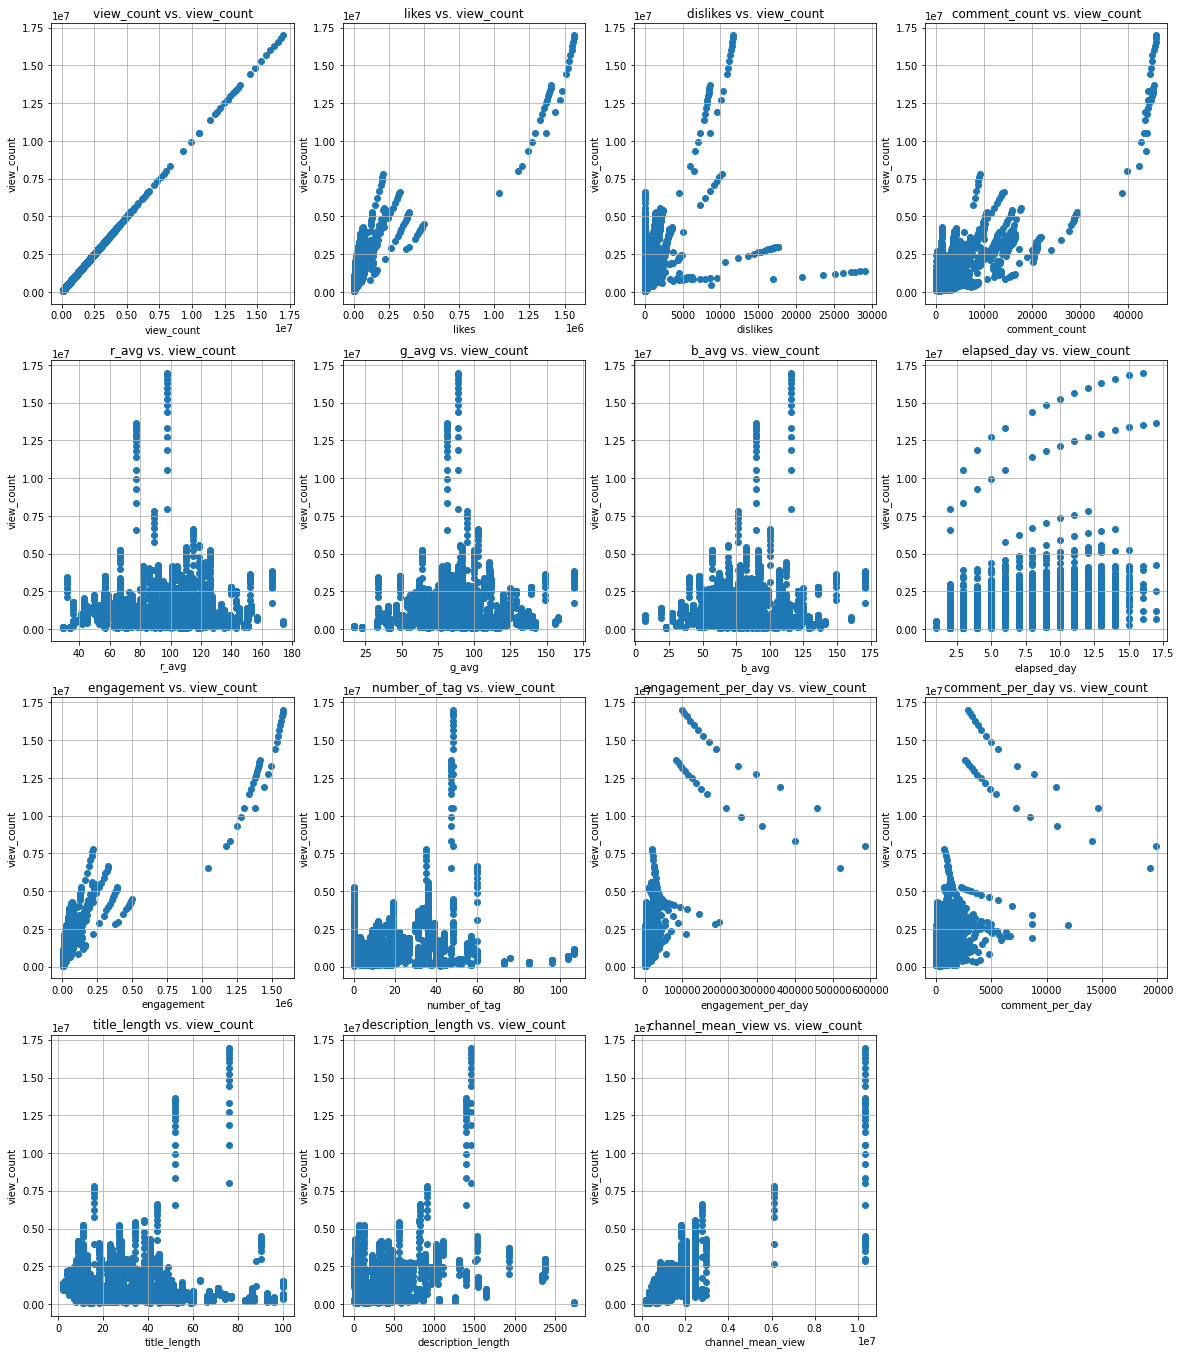

In [45]:
plt.figure(figsize=(20, 30))

for i in range(1, len(df.describe().columns)):
    plt.subplot(5, 4, i)
    title = str(df.describe().columns[i]) + ' vs. view_count'
    plt.title(title)
    plt.xlabel(df.describe().columns[i])
    plt.ylabel('view_count')
    plt.grid()
    plt.scatter(df[df.describe().columns[i]], df['view_count'])  

In [46]:
list(df)

['video_id',
 'title',
 'publishedAt',
 'channelId',
 'channelTitle',
 'categoryId',
 'trending_date',
 'tags',
 'view_count',
 'likes',
 'dislikes',
 'comment_count',
 'thumbnail_link',
 'comments_disabled',
 'ratings_disabled',
 'description',
 'publish_date',
 'trend_date',
 'r_avg',
 'g_avg',
 'b_avg',
 'elapsed_day',
 'engagement',
 'number_of_tag',
 'engagement_per_day',
 'comment_per_day',
 'title_length',
 'description_length',
 'channel_mean_view']

In [47]:
features = ['likes', 'dislikes', 'comment_count', 'r_avg', 'g_avg', 'b_avg', 'elapsed_day', 'number_of_tag',
            'engagement_per_day', 'comment_per_day',
            'description_length', 'title_length', 'channel_mean_view']

                    likes  dislikes  comment_count  r_avg  g_avg  b_avg  \
likes                 1.0       NaN            NaN    NaN    NaN    NaN   
dislikes              NaN       1.0            NaN    NaN    NaN    NaN   
comment_count         NaN       NaN            1.0    NaN    NaN    NaN   
r_avg                 NaN       NaN            NaN    1.0    NaN    NaN   
g_avg                 NaN       NaN            NaN    NaN    1.0    NaN   
b_avg                 NaN       NaN            NaN    NaN    NaN    1.0   
elapsed_day           NaN       NaN            NaN    NaN    NaN    NaN   
number_of_tag         NaN       NaN            NaN    NaN    NaN    NaN   
engagement_per_day    NaN       NaN            NaN    NaN    NaN    NaN   
comment_per_day       NaN       NaN            NaN    NaN    NaN    NaN   
description_length    NaN       NaN            NaN    NaN    NaN    NaN   
title_length          NaN       NaN            NaN    NaN    NaN    NaN   
channel_mean_view     NaN

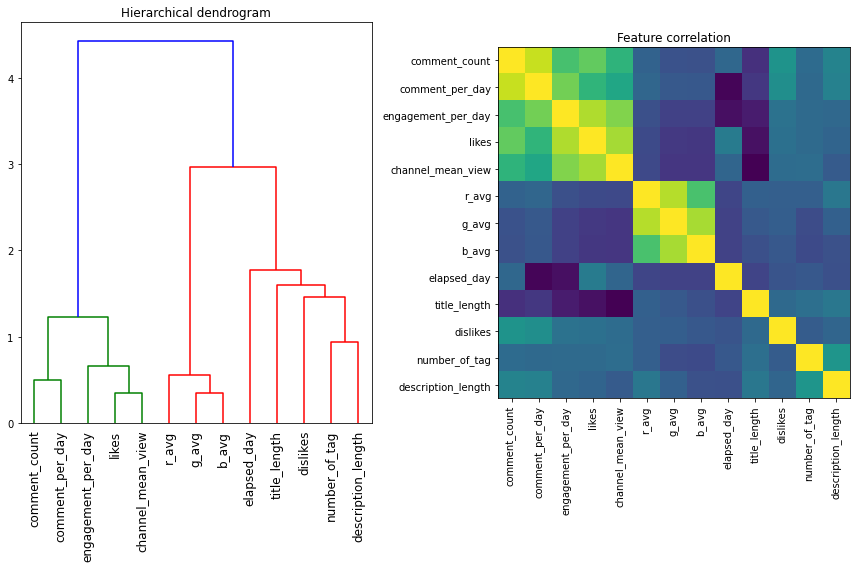

In [48]:
X_input = df[features]
cor_table = X_input.corr()

print(cor_table[cor_table > 0.9])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.set_title('Hierarchical dendrogram')
corr = spearmanr(X_input).correlation
pd.DataFrame(corr)
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=features, ax=ax1, leaf_rotation=90)

dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_title('Feature correlation')
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])

fig.tight_layout()

In [49]:
y_output = df['view_count']

X_train, X_test, y_train, y_test = train_test_split(X_input, y_output, random_state=42)

---

In [50]:
mm_scaler = MinMaxScaler()
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

In [51]:
model_name = []
train_perf = []
test_perf = []

In [52]:
len(X_train)

2835

Fitting 5 folds for each of 1900 candidates, totalling 9500 fits
Best_estimator: ElasticNet(alpha=0.0008, l1_ratio=0.9900000000000001, max_iter=100000000,
           random_state=42, tol=0.0316)
Best_params: {'alpha': 0.0008, 'l1_ratio': 0.9900000000000001, 'tol': 0.0316}
Best_score: 0.8891281687824488
Train score: 0.8863029268286335
Test score: 0.8173174930927493


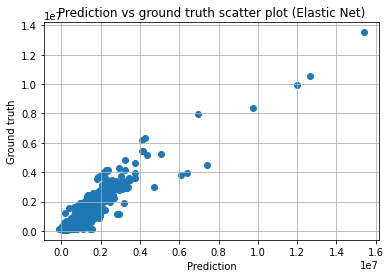

In [53]:
# 카테고리 23 최근 1년 데이터 중 학습데이터(2835개) : 실행 시간 44초 소요

en_model = ElasticNet(max_iter=100000000, random_state=42)

en_param = {
    'l1_ratio': np.arange(0.9, 0.995, 0.005),
    'alpha': np.arange(0.0008, 0.0028, 0.0001),
    'tol': [1e-2, 3.16e-2, 1e-1, 3.16e-1, 1e0]
}

clf = GridSearchCV(estimator=en_model, param_grid=en_param, n_jobs=-1, verbose=3)

clf.fit(X_train_scaled, y_train)
y_train_pred = clf.predict(X_train_scaled)
y_test_pred = clf.predict(X_test_scaled)

print('Best_estimator:', clf.best_estimator_)
print('Best_params:', clf.best_params_)
print('Best_score:', clf.best_score_)

train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test score:', test_score)

model_name.append('Elastic Net')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (Elastic Net)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test);

In [54]:
en_model = ElasticNet(alpha=0.0008, l1_ratio=0.9900000000000001, tol=0.0316, max_iter=100000000, random_state=42)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best_estimator: RandomForestRegressor(max_depth=30, n_estimators=76, n_jobs=-1, random_state=42)
Best_params: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 76}
Best_score: 0.9861646311295796
Train score: 0.9986441106996253
Test  score: 0.9890824685079341


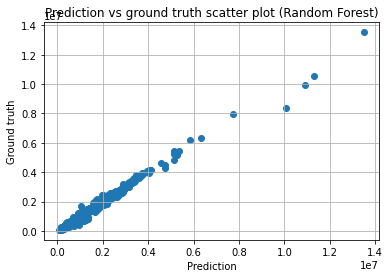

In [55]:
# 카테고리 23 최근 1년 데이터 중 학습데이터(2835개) : 실행 시간 2분 56초 소요

rf_model = RandomForestRegressor(n_jobs=-1, random_state=42)

rf_param = {'n_estimators': range(76, 136, 20),
            'max_depth': range(30, 42, 4),
            'min_samples_split': range(2, 5, 1)}

clf = GridSearchCV(estimator=rf_model, param_grid=rf_param, n_jobs=-1, verbose=2)

clf.fit(X_train_scaled, y_train)
y_train_pred = clf.predict(X_train_scaled)
y_test_pred = clf.predict(X_test_scaled)

print('Best_estimator:', clf.best_estimator_)
print('Best_params:', clf.best_params_)
print('Best_score:', clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Random Forest')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (Random Forest)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test);

In [56]:
rf_model = RandomForestRegressor(n_estimators=76, max_depth=30, min_samples_split=2, n_jobs=-1, random_state=42)

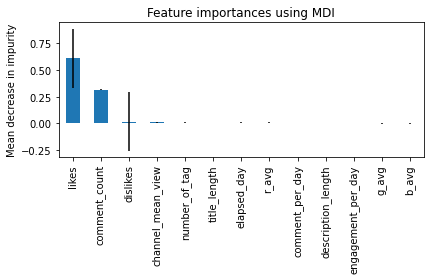

In [57]:
rf_model.fit(X_train_scaled, y_train)

feature_names = ['feature {i}' for i in range(X_train_scaled.shape[1])]

importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features)
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

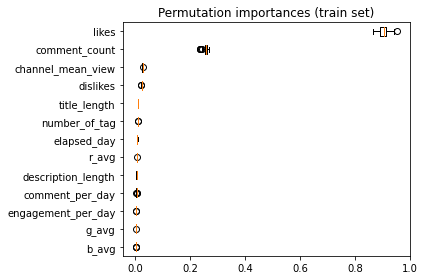

In [58]:
# 카테고리 23 최근 1년 데이터 중 학습데이터(2835개) : 실행 시간 1분 14초 소요

result = permutation_importance(rf_model, X_train_scaled, y_train, n_repeats=100, n_jobs=-1, random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation importances (train set)")
fig.tight_layout()

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[02:41:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best_estimator: XGBRegressor(max_depth=4, n_estimators=120, n_jobs=-1, random_state=42,
             reg_alpha=0.01)
Best_params: {'max_depth': 4, 'n_estimators': 120, 'reg_alpha': 0.01, 'reg_lambda': 1}
Best_score: 0.9828879160877211
Train score: 0.9935711238036457
Test  score: 0.9796042855812146


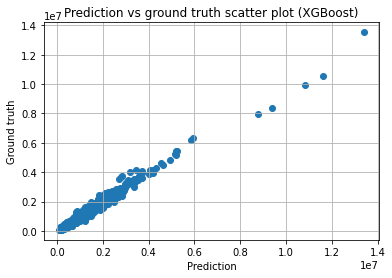

In [59]:
# 카테고리 23 최근 1년 데이터 중 학습데이터(2835개) : 실행 시간 33초 소요

xgb_model = XGBRegressor(n_jobs=-1, random_state=42)

xgb_param = {'n_estimators': range(80, 140, 20),
             'max_depth': range(2, 5, 1),
             'reg_alpha': [1e-2, 3.16e-2, 1e-1],
             'reg_lambda': [0.1, 0.316, 1]}

xgb_clf = GridSearchCV(estimator=xgb_model, param_grid=xgb_param, n_jobs=-1, verbose=2, cv=3)

xgb_clf.fit(X_train_scaled, y_train)
y_train_pred = xgb_clf.predict(X_train_scaled)
y_test_pred = xgb_clf.predict(X_test_scaled)

print('Best_estimator:', xgb_clf.best_estimator_)
print('Best_params:', xgb_clf.best_params_)
print('Best_score:', xgb_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('XGBoost')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (XGBoost)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test);

In [60]:
xgb_model = XGBRegressor(max_depth=4, n_estimators=120, reg_alpha=0.01, reg_lambda=1, n_jobs=-1, random_state=42)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best_estimator: SVR(C=100000000.0, gamma=0.316)
Best_params: {'C': 100000000.0, 'gamma': 0.316}
Best_score: 0.9545894093839479
Train score: 0.9604391731220492
Test  score: 0.9263928418618677


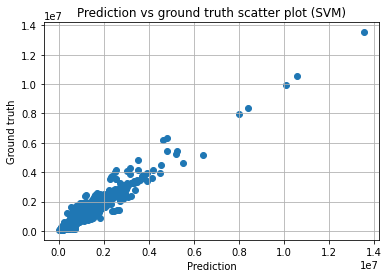

In [61]:
# 카테고리 23 최근 1년 데이터 중 학습데이터(2835개) : 실행 시간 39초 소요

svr_model = SVR()

svr_param = {'C': [3.16e7, 1e8],
             'gamma': [0.1, 0.316]}

svr_clf = GridSearchCV(estimator=svr_model, param_grid=svr_param, n_jobs=-1, verbose=3, cv=3)

svr_clf.fit(X_train_scaled, y_train)
y_train_pred = svr_clf.predict(X_train_scaled)
y_test_pred = svr_clf.predict(X_test_scaled)

print('Best_estimator:', svr_clf.best_estimator_)
print('Best_params:', svr_clf.best_params_)
print('Best_score:', svr_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('SVM')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (SVM)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test);

In [62]:
svr_model = SVR(C=100000000.0, gamma=0.316)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best_estimator: KNeighborsRegressor(leaf_size=1, n_jobs=-1, n_neighbors=2, weights='distance')
Best_params: {'leaf_size': 1, 'n_neighbors': 2, 'weights': 'distance'}
Best_score: 0.972756149647101
Train score: 1.0
Test  score: 0.9774574366031782


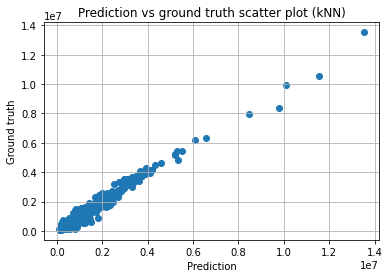

In [63]:
# 카테고리 23 최근 1년 데이터 중 학습데이터(2835개) : 실행 시간 12초 소요

knn_model = KNeighborsRegressor(n_jobs=-1)

knn_param = {'n_neighbors': range(1, 6, 1),
             'weights': ['uniform', 'distance'],
             'leaf_size': range(1, 5, 1)}

knn_clf = GridSearchCV(estimator=knn_model, param_grid=knn_param, n_jobs=-1, verbose=3)

knn_clf.fit(X_train_scaled, y_train)
y_train_pred = knn_clf.predict(X_train_scaled)
y_test_pred = knn_clf.predict(X_test_scaled)

print('Best_estimator:', knn_clf.best_estimator_)
print('Best_params:', knn_clf.best_params_)
print('Best_score:', knn_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', r2_score(y_train_pred, y_train))
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', r2_score(y_test_pred, y_test))


model_name.append('kNN')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (kNN)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test);

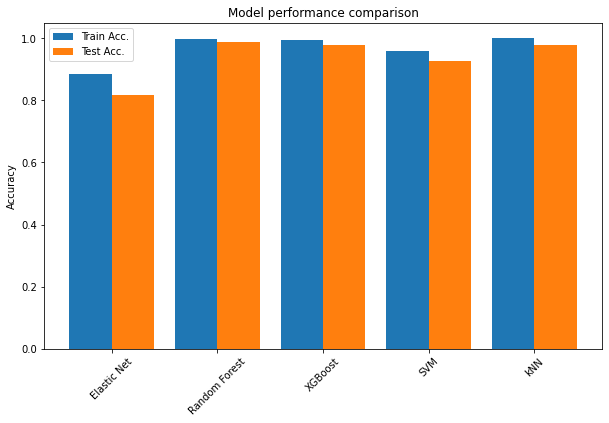

In [64]:
plt.figure(figsize=(10,6))
plt.title('Model performance comparison')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')

x = np.arange(len(model_name))
plt.xticks(x, model_name)
plt.bar(x - 0.2, train_perf, width=0.4, label='Train Acc.');
plt.bar(x + 0.2, test_perf, width=0.4, label='Test Acc.');
plt.legend();

In [65]:
pd.DataFrame({
    'model_name': model_name,
    'test_perf': test_perf
}).sort_values(by='test_perf', ascending=False)

,model_name,test_perf
1,Random Forest,0.989082
2,XGBoost,0.979604
4,kNN,0.977457
3,SVM,0.926393
0,Elastic Net,0.817317


1 Ensemble train score: 0.9986441106996253
1 Ensemble test  score: 0.9890824685079341
2 Ensemble train score: 0.9973963717006878
2 Ensemble test  score: 0.987195464942993
3 Ensemble train score: 0.9948643155451316
3 Ensemble test  score: 0.9804611375386876
4 Ensemble train score: 0.9914540085915
4 Ensemble test  score: 0.9762226084865466
5 Ensemble train score: 0.9838166946770015
5 Ensemble test  score: 0.9625215513901084


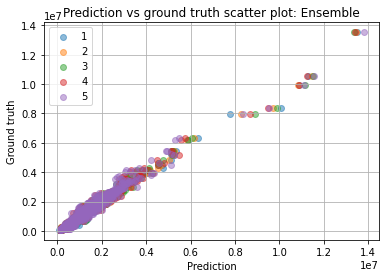

In [66]:
ensemble_list = [('rf', rf_model),('xgb', xgb_model), ('knn', knn_model), ('svm', svr_model), ('en', en_model)]

voting_est = []

for idx, target_model in enumerate(ensemble_list):
    voting_est.append(target_model)

    voting_clf = VotingRegressor(estimators=voting_est, n_jobs=-1)
    voting_clf.fit(X_train_scaled, y_train)
    y_train_pred = voting_clf.predict(X_train_scaled)
    y_test_pred = voting_clf.predict(X_test_scaled)
    print(idx + 1, 'Ensemble train score:', r2_score(y_train_pred, y_train))
    print(idx + 1, 'Ensemble test  score:', r2_score(y_test_pred, y_test))

    plt.scatter(y_test_pred, y_test, label=str(idx + 1), alpha=0.5)
    title = 'Prediction vs ground truth scatter plot: Ensemble'     
    plt.title(title)
    plt.xlabel('Prediction')
    plt.ylabel('Ground truth')
    plt.grid()
    plt.legend()

In [67]:
voting_clf = VotingRegressor(estimators=[('rf', rf_model),('xgb', xgb_model), ('knn', knn_model), ('svm', svr_model), ('en', en_model)], n_jobs=-1)
voting_clf.fit(X_train_scaled, y_train)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(max_depth=30,
                                                   n_estimators=76, n_jobs=-1,
                                                   random_state=42)),
                            ('xgb',
                             XGBRegressor(max_depth=4, n_estimators=120,
                                          n_jobs=-1, random_state=42,
                                          reg_alpha=0.01)),
                            ('knn', KNeighborsRegressor(n_jobs=-1)),
                            ('svm', SVR(C=100000000.0, gamma=0.316)),
                            ('en',
                             ElasticNet(alpha=0.0008,
                                        l1_ratio=0.9900000000000001,
                                        max_iter=100000000, random_state=42,
                                        tol=0.0316))],
                n_jobs=-1)

---

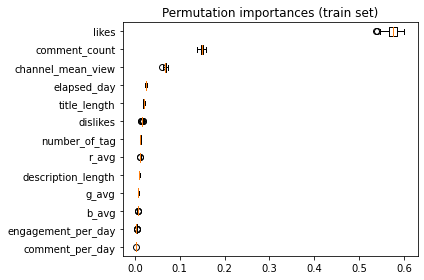

In [68]:
# 카테고리 23 최근 1년 데이터 중 학습데이터(2835개) : 실행 시간 14분 6초 소요

result = permutation_importance(voting_clf, X_train_scaled, y_train, n_repeats=100, n_jobs=-1, random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation importances (train set)")
fig.tight_layout()

---